In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

import gc
import logging
import warnings

warnings.filterwarnings('ignore')

In [2]:
!pip install tabulate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/models/"

In [5]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue

        # only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # this is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [6]:
print("Loading and reducing memory usage for data files...")
df = pd.read_parquet(f'{DATA_PATH}final_m5_model_data.parquet')
df = reduce_mem_usage(df)
print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 10068.35 Mb to 6007.70 Mb (40.3% reduction)

Initial data loading complete.


In [7]:
df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,sell_price,date,wday,...,sales_rolling_mean_7,sales_rolling_mean_28,price_lag_7,price_lag_28,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,day_of_week_cos
0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_29,2,2.0,2011-02-26,1,...,1.857143,1.392857,2.0,2.0,0.866025,0.5,-0.848644,0.528964,0.781832,0.62349
1,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,d_29,0,2.0,2011-02-26,1,...,3.428571,2.107143,2.0,2.0,0.866025,0.5,-0.848644,0.528964,0.781832,0.62349
2,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,d_29,6,2.0,2011-02-26,1,...,0.857143,1.428571,2.0,2.0,0.866025,0.5,-0.848644,0.528964,0.781832,0.62349
3,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,d_29,1,2.0,2011-02-26,1,...,0.714286,0.571429,2.0,2.0,0.866025,0.5,-0.848644,0.528964,0.781832,0.62349
4,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,d_29,0,2.0,2011-02-26,1,...,0.714286,0.392857,2.0,2.0,0.866025,0.5,-0.848644,0.528964,0.781832,0.62349


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 42 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   item_id                 category      
 1   dept_id                 category      
 2   cat_id                  category      
 3   store_id                category      
 4   state_id                category      
 5   d                       category      
 6   sales                   int16         
 7   sell_price              float32       
 8   date                    datetime64[ns]
 9   wday                    int8          
 10  month                   int8          
 11  year                    int16         
 12  snap_CA                 int8          
 13  snap_TX                 int8          
 14  snap_WI                 int8          
 15  event_name_1            category      
 16  event_type_1            category      
 17  event_name_2            category      
 18  

In [9]:
print(df.shape)

(58327370, 42)


In [10]:
gc.collect()

71

In [11]:
print(df.isnull().sum().to_markdown())

|                        |   0 |
|:-----------------------|----:|
| item_id                |   0 |
| dept_id                |   0 |
| cat_id                 |   0 |
| store_id               |   0 |
| state_id               |   0 |
| d                      |   0 |
| sales                  |   0 |
| sell_price             |   0 |
| date                   |   0 |
| wday                   |   0 |
| month                  |   0 |
| year                   |   0 |
| snap_CA                |   0 |
| snap_TX                |   0 |
| snap_WI                |   0 |
| event_name_1           |   0 |
| event_type_1           |   0 |
| event_name_2           |   0 |
| event_type_2           |   0 |
| has_sale               |   0 |
| quarter                |   0 |
| week                   |   0 |
| day_of_week            |   0 |
| day_of_month           |   0 |
| day_of_year            |   0 |
| weekend                |   0 |
| price_mean             |   0 |
| price_relative_to_mean |   0 |
| price_ch

## Note

1. The "Categorical Feature" Problem:

This is the most important reason. Linear models like LinearRegression and Ridge can't handle categorical features like item_id, store_id, or dept_id directly.

The technically correct way to use them is one-hot encoding but it is impossible. Because our item_id column has over 3,000 unique items. One-hot encoding it would add 3,000+ new columns to the DataFrame. Doing this for all categorical features would add thousands of columns, exploding your DataFrame from 33 features to ~3,200+ features.

So, definitely, the notebook will instantly crash from a memory explosion. (out of memory usage)

That's why tree models are the solution. They are specifically designed to handle high-cardinality categorical features without one-hot encoding, saving us from this memory crisis.

2. Linear models can only find simple, a straight-line relationships.

The Heatmap from the EDA and Feature Engineering step proved this:
- We saw that snap_CA and weekend have a 0.00 correlation with sales. A linear model will look at this 0.00 and conclude that "this feature is useless". But in reality, we know a weekend day boosts sales, and a snap day boosts food sales. So, this is a complex, non-linear rule.

Tree models are the solution here, too. They excel at finding these complex, non-linear patterns and "if-then" rules. A tree model can easily learn:

- "IF day_of_week is a weekend AND category is 'FOODS', THEN sales go up"

A linear model can never discover this rule.

Summary: We have to move to tree models because linear models can't handle your most important features (the categories) and can't understand the most important patterns (the non-linear rules).

In [12]:
gc.collect()

0

## LightGBM

In [13]:
!pip install optuna

In [14]:
!pip install optuna-integration

In [15]:
!pip install shap

In [16]:
!pip install lightgbm

In [17]:
import optuna
import shap

import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit

import time
import tracemalloc

In [18]:
cat_features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'
]

print("Converting categorical features to 'category' type...")

for col in cat_features:
    df[col] = df[col].astype('category')

print("Encoding complete.")

Converting categorical features to 'category' type...
Encoding complete.


In [19]:
gc.collect()

0

In [20]:
features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI',

    'wday', 'month', 'year', 'quarter', 'week',
    'day_of_week', 'day_of_month', 'day_of_year', 'weekend',

    'month_sin', 'month_cos',
    'day_of_month_sin', 'day_of_month_cos',
    'day_of_week_sin', 'day_of_week_cos',

    'sell_price',
    'price_mean',
    'price_relative_to_mean',
    'price_change_lag',
    'price_lag_7',
    'price_lag_28',

    'sales_lag_1',
    'sales_lag_7',
    'sales_lag_28',
    'sales_rolling_mean_7',
    'sales_rolling_mean_28'
]

target = 'sales'
missing_cols = [col for col in features if col not in df.columns]
if missing_cols:
    print(f"The following features are missing from df: {missing_cols}")
else:
    print(f"All {len(features)} features are present. Ready to train!")

print(f"Target variable: {target}")
print(f"Total features being used: {len(features)}")

All 38 features are present. Ready to train!
Target variable: sales
Total features being used: 38


In [21]:
print("Sorting dataframe...")
df = df.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)

VALID_DAYS = 28
split_date = df['date'].unique()[-VALID_DAYS]
print(f"Splitting data at date: {split_date}")


mask_train = df['date'] < split_date
mask_valid = df['date'] >= split_date

print("Creating Training sets...")
X_train = df.loc[mask_train, features]
y_train = df.loc[mask_train, target]

print("Creating Validation sets...")
X_valid = df.loc[mask_valid, features]
y_valid = df.loc[mask_valid, target]

print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

del df, mask_train, mask_valid
gc.collect()

Sorting dataframe...
Splitting data at date: 2016-04-25 00:00:00
Creating Training sets...
Creating Validation sets...
Training set shape:   (57473650, 38)
Validation set shape: (853720, 38)


0

In [22]:
print("Creating LightGBM Datasets")

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_features,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=cat_features,
    reference=train_data,
    free_raw_data=False
)

print("Datasets ready.")

Creating LightGBM Datasets
Datasets ready.


In [23]:
def objective(trial):
    param_grid = {
        'objective': 'tweedie',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
        'seed': 42,

        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9),

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    rmse_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):

        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            param_grid,
            dtrain,
            num_boost_round=1000,
            valid_sets=[dvalid],
            callbacks=[
                LightGBMPruningCallback(trial, "rmse"),
                lgb.early_stopping(stopping_rounds=30, verbose=False)
            ]
        )

        preds = model.predict(X_val, num_iteration=model.best_iteration)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)


In [24]:
print("Starting Optuna optimization...")
tracemalloc.start()
start_time_optuna = time.time()

# running 25 trials
study = optuna.create_study(direction='minimize', study_name="LGBM_Tuning")
study.optimize(objective, n_trials=25)

end_time_optuna = time.time()
_, peak_ram_optuna = tracemalloc.get_traced_memory()
tracemalloc.stop()

optuna_duration = end_time_optuna - start_time_optuna
print(f"\nOptuna Optimization Complete.")
print(f"  - Duration: {optuna_duration / 60:.2f} minutes")
print(f"  - Peak RAM usage: {peak_ram_optuna / 1024**3:.2f} GB")
print(f"  - Best RMSE: {study.best_value}")
print(f"  - Best Parameters: {study.best_params}")

[I 2025-12-08 05:43:30,636] A new study created in memory with name: LGBM_Tuning


Starting Optuna optimization...


[I 2025-12-08 05:53:29,827] Trial 0 finished with value: 1.8819488641519924 and parameters: {'tweedie_variance_power': 1.483967194606589, 'learning_rate': 0.04331370182676064, 'num_leaves': 221, 'max_depth': 4, 'min_data_in_leaf': 196, 'feature_fraction': 0.503929947044561, 'bagging_fraction': 0.5059076314542801, 'bagging_freq': 3, 'lambda_l1': 9.350832611892818, 'lambda_l2': 9.160606135604937}. Best is trial 0 with value: 1.8819488641519924.
[I 2025-12-08 05:56:20,017] Trial 1 finished with value: 1.9121516120207325 and parameters: {'tweedie_variance_power': 1.5825873896414389, 'learning_rate': 0.15757641340318518, 'num_leaves': 157, 'max_depth': 6, 'min_data_in_leaf': 84, 'feature_fraction': 0.6499487869985403, 'bagging_fraction': 0.8575199412282559, 'bagging_freq': 7, 'lambda_l1': 3.5340202918747874, 'lambda_l2': 1.8560082896193952}. Best is trial 0 with value: 1.8819488641519924.
[I 2025-12-08 06:09:22,883] Trial 2 finished with value: 1.8914276709513185 and parameters: {'tweedie_v


Optuna Optimization Complete.
  - Duration: 49.25 minutes
  - Peak RAM usage: 13.09 GB
  - Best RMSE: 1.8819488641519924
  - Best Parameters: {'tweedie_variance_power': 1.483967194606589, 'learning_rate': 0.04331370182676064, 'num_leaves': 221, 'max_depth': 4, 'min_data_in_leaf': 196, 'feature_fraction': 0.503929947044561, 'bagging_fraction': 0.5059076314542801, 'bagging_freq': 3, 'lambda_l1': 9.350832611892818, 'lambda_l2': 9.160606135604937}


In [25]:
print("Training Final LightGBM Model on Full Data...")

# get best params from Optuna
final_params = study.best_params

final_params.update({
    'objective': 'tweedie',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': 42,
    # 'verbose': -1
    'verbosity': -1
})

tracemalloc.start()
start_time_train = time.time()

final_model = lgb.train(
    final_params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

end_time_train = time.time()
_, peak_ram_train = tracemalloc.get_traced_memory()
tracemalloc.stop()

train_duration = end_time_train - start_time_train
print(f"Final Training Complete.")
print(f"  - Duration: {train_duration / 60:.2f} minutes")
print(f"  - Peak RAM usage: {peak_ram_train / 1024**3:.2f} GB")

Training Final LightGBM Model on Full Data...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.21216	valid_1's rmse: 2.0461
[200]	training's rmse: 2.10718	valid_1's rmse: 1.99011
[300]	training's rmse: 2.07275	valid_1's rmse: 1.9789
[400]	training's rmse: 2.06074	valid_1's rmse: 1.97506
[500]	training's rmse: 2.052	valid_1's rmse: 1.97162
[600]	training's rmse: 2.04742	valid_1's rmse: 1.96992
[700]	training's rmse: 2.04225	valid_1's rmse: 1.967
[800]	training's rmse: 2.03678	valid_1's rmse: 1.9646
[900]	training's rmse: 2.03417	valid_1's rmse: 1.96351
[1000]	training's rmse: 2.02992	valid_1's rmse: 1.96191
[1100]	training's rmse: 2.0271	valid_1's rmse: 1.96052
[1200]	training's rmse: 2.0247	valid_1's rmse: 1.95912
[1300]	training's rmse: 2.02202	valid_1's rmse: 1.95788
[1400]	training's rmse: 2.01941	valid_1's rmse: 1.95647
[1500]	training's rmse: 2.01745	valid_1's rmse: 1.95577
[1600]	training's rmse: 2.01556	valid_1's rmse: 1.95438
[1700]	training

In [26]:
print("Evaluating Final Model...")
preds = final_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, preds))
mse = mean_squared_error(y_valid, preds)
mae = mean_absolute_error(y_valid, preds)

print(f"Final Validation RMSE: {rmse:.4f}")
print(f"Final Validation MSE: {rmse:.4f}")
print(f"Final Validation MAE:  {mae:.4f}")


Evaluating Final Model...
Final Validation RMSE: 1.9514
Final Validation MSE: 1.9514
Final Validation MAE:  0.9904


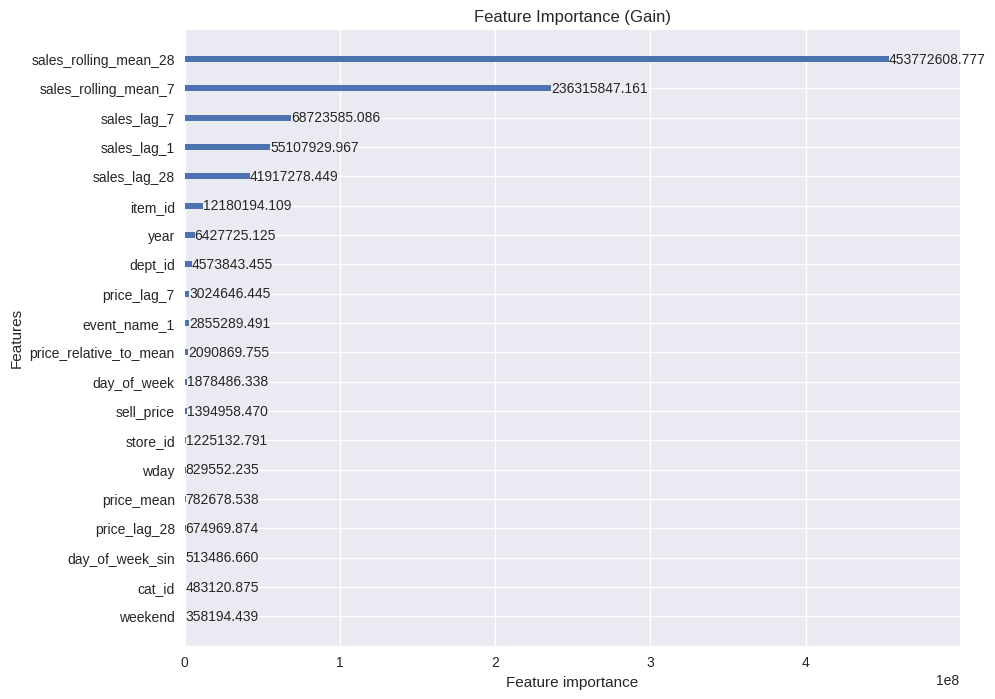

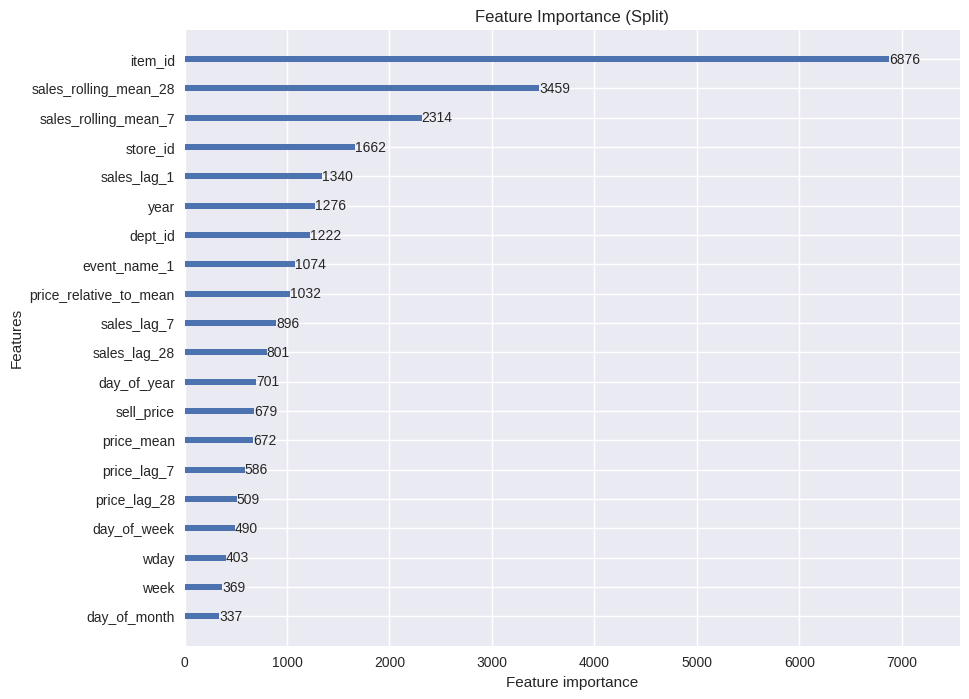

In [27]:
lgb.plot_importance(final_model, max_num_features=20, importance_type='gain', figsize=(10, 8), title='Feature Importance (Gain)')
plt.show()

lgb.plot_importance(final_model, max_num_features=20, importance_type='split', figsize=(10, 8), title='Feature Importance (Split)')
plt.show()

In [28]:
print("Saving model...")
final_model.save_model(f'{MODEL_PATH}final_m5_model_lightgbm_tuned.json')
print("\n Model saved successfully...")

Saving model...

 Model saved successfully...


In [29]:
valid_preds_xgb_tuned = final_model.predict(X_valid)

Running SHAP Analysis...


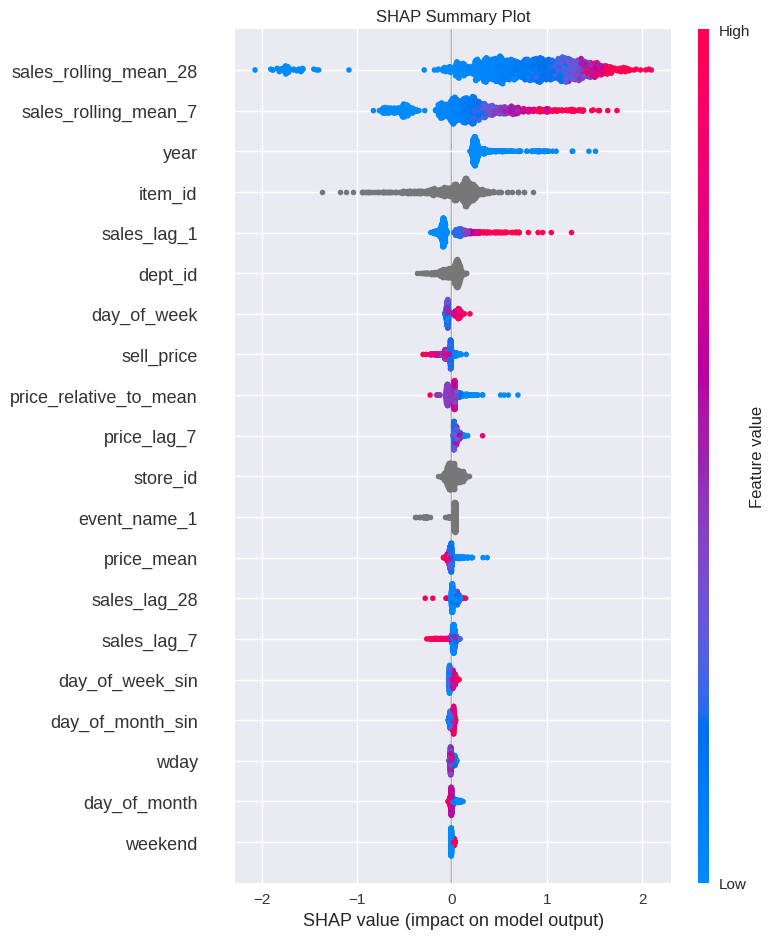

In [30]:
print("Running SHAP Analysis...")

# create a sample background (LightGBM is fast, so we can use a slightly larger sample)
X_train_sample = X_train.sample(1000, random_state=42)
X_valid_sample = X_valid.sample(1000, random_state=42)

# TreeExplainer works natively with LightGBM
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_valid_sample)

plt.figure(figsize=(12, 8))
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_valid_sample)

In [31]:
gc.collect()

24377

In [32]:
gc.collect()

462